In [103]:
import glob
import os
import numpy as np
import tensorflow as tf
from music21 import *
import random
from matplotlib import pyplot as plt
from fractions import Fraction
import json

# constants
NUM_PIANO_KEYS = 88
A0_MIDI_OFFSET = 21

In [341]:
notes = []
offsets = []
durations = []

# change path to read in different midi files
for file in glob.glob('jazz_solos_midi/Swing/*.mid', recursive=True):
    mid = converter.parse(file)
    notes_to_parse = None
    prev_offset = 0
          
    notes_to_parse = mid.flatten().notes
    
    for element in notes_to_parse:
        if isinstance(element, note.Note):
            # One hot encoding of pitch by piano key
            arr = np.zeros(NUM_PIANO_KEYS)
            try:
                arr[element.pitch.midi - A0_MIDI_OFFSET] = 1
            except IndexError:
                # removes files that had note outside the range of a piano
                os.remove(file)
                break
                
        
            notes.append(arr)
            
            durations.append(str(element.quarterLength))
            
            offsets.append(round(float(element.offset - prev_offset), 3))
            prev_offset = element.offset
            
        elif isinstance(element, chord.Chord):
            # if an element is a chord, encode each note separately
            isFirstNote = True
            for n in element:
                arr = np.zeros(NUM_PIANO_KEYS)
                try:
                    arr[n.pitch.midi - A0_MIDI_OFFSET] = 1
                except IndexError:
                    try:
                        os.remove(file)
                        break
                    except FileNotFoundError:
                        break
                    
                notes.append(arr)
                
                durations.append(str(n.quarterLength))
                
                # offset of first note is chord offset, offset of other notes is 0
                if isFirstNote:
                    offsets.append(round(float(element.offset - prev_offset), 3))
                    prev_offset = element.offset
                    isFirstNote = False
                else:
                    offsets.append(float(0))

notes = np.asarray(notes)
len(notes)

2472

In [342]:
# create dictionaries to one hot encode and decode
duration_map = {d: i for i, d in enumerate(sorted(set(durations)))}
reverse_duration = {i: d for i, d in enumerate(sorted(set(durations)))}
offset_map = {o: i for i, o in enumerate(sorted(set(offsets)))}
reverse_offset = {i: o for i, o in enumerate(sorted(set(offsets)))}

In [343]:
# used to read in previous dictionaries, used for when transfer learning
# so that the encodings were consistent between models
# offset_map = dict()
# with open('mappings/offset_map.txt') as f:
#     for line in f:
#         key, value = line.strip().split(":")
#         offset_map[float(key)] = int(value)
# with open('mappings/duration_map.txt') as json_file:
#     duration_map = json.load(json_file)  
# reverse_duration = dict()
# with open('mappings/reverse_duration.txt') as f:
#     for line in f:
#         key, value = line.strip().split(":")
#         reverse_duration[int(key)] = value
# reverse_offset = dict()
# with open('mappings/reverse_offset.txt') as f:
#     for line in f:
#         key, value = line.strip().split(":")
#         reverse_offset[int(key)] = float(value)

In [346]:
# encodes the durations
temp = []
size = len(duration_map)
for duration in durations:
    arr = np.zeros(size)
    arr[duration_map[duration]] = 1
    temp.append(arr)
durations = np.asarray(temp)

In [347]:
#encodes the offsets
temp = []
size = len(offset_map)
for offset in offsets:
    arr = np.zeros(size)
    try:
        arr[offset_map[offset]] = 1
    except IndexError:
        print(offset, offset_map[offset])
        print(arr[offset_map[offset]])
    temp.append(arr)
offsets = np.asarray(temp)

In [351]:
# combines the three vectors per note into a single one
train_notes = np.concatenate([notes, durations, offsets], axis = 1)

# creates groupings of 50 inputs notes for each output note for training
seq_length = 50
inputs = []
note_outputs = []
duration_outputs = []
offset_outputs = []
for i in range(len(notes) - seq_length):
    inputs.append(train_notes[i : i + seq_length])
    
    note_outputs.append(notes[i + seq_length])
    duration_outputs.append(durations[i + seq_length])
    offset_outputs.append(offsets[i + seq_length])
    
input_size = len(inputs)
inputs = np.asarray(inputs)
inputs.reshape(input_size, seq_length, len(train_notes[0]))

note_outputs = np.asarray(note_outputs)
duration_outputs = np.asarray(duration_outputs)
offset_outputs = np.asarray(offset_outputs)

In [352]:
input_shape = inputs[0].shape
learning_rate = 0.005

inp = tf.keras.Input(input_shape)
lstm = tf.keras.layers.LSTM(512)(inp)
drop = tf.keras.layers.Dropout(0.5)(lstm)
dense = tf.keras.layers.Dense(256)(drop)
out = {
    "pitch": tf.keras.layers.Dense(NUM_PIANO_KEYS, name = "pitch", activation = "softmax")(dense),
    "duration": tf.keras.layers.Dense(len(duration_map), name = "duration", activation = "softmax")(dense),
    "offset": tf.keras.layers.Dense(len(offset_map), name = "offset", activation = "softmax")(dense),
}

model = tf.keras.Model(inp, out)

model.compile(
    loss = "categorical_crossentropy",
    loss_weights = {
        'pitch': 1.0,
        'step': 1.0,
        'duration':1.0,
    },
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate = learning_rate),
    metrics = ["accuracy"]
)

model.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 50, 177)]            0         []                            
                                                                                                  
 lstm_10 (LSTM)              (None, 512)                  1413120   ['input_11[0][0]']            
                                                                                                  
 dropout_10 (Dropout)        (None, 512)                  0         ['lstm_10[0][0]']             
                                                                                                  
 dense_10 (Dense)            (None, 256)                  131328    ['dropout_10[0][0]']          
                                                                                           

In [311]:
# model.load_weights('weights/jazznet')

In [353]:
%%time
epochs = 25

history = model.fit(
    x = inputs,
    y = {"pitch": note_outputs, "duration": duration_outputs, "offset": offset_outputs},
    epochs = epochs,
    callbacks = tf.keras.callbacks.EarlyStopping(
        monitor = 'loss',
        patience = 5,
        verbose = 1,
        restore_best_weights = True),
    validation_split = 0.2
)

Epoch 1/25
61/61 [==============================] - 8s 116ms/step - loss: 8.9475 - duration_loss: 2.3491 - offset_loss: 3.0697 - pitch_loss: 3.5287 - duration_accuracy: 0.2586 - offset_accuracy: 0.1791 - pitch_accuracy: 0.0847 - val_loss: 7.8572 - val_duration_loss: 2.0121 - val_offset_loss: 2.6714 - val_pitch_loss: 3.1736 - val_duration_accuracy: 0.2866 - val_offset_accuracy: 0.3093 - val_pitch_accuracy: 0.1216
Epoch 2/25
61/61 [==============================] - 7s 110ms/step - loss: 7.7089 - duration_loss: 1.9335 - offset_loss: 2.5241 - pitch_loss: 3.2514 - duration_accuracy: 0.2814 - offset_accuracy: 0.2881 - pitch_accuracy: 0.0955 - val_loss: 7.4807 - val_duration_loss: 2.0285 - val_offset_loss: 2.2858 - val_pitch_loss: 3.1663 - val_duration_accuracy: 0.2536 - val_offset_accuracy: 0.3835 - val_pitch_accuracy: 0.1093
Epoch 3/25
61/61 [==============================] - 7s 113ms/step - loss: 7.2148 - duration_loss: 1.8919 - offset_loss: 2.2572 - pitch_loss: 3.0657 - duration_accuracy:

Epoch 21/25
61/61 [==============================] - 7s 111ms/step - loss: 1.6910 - duration_loss: 0.6397 - offset_loss: 0.4281 - pitch_loss: 0.6232 - duration_accuracy: 0.7661 - offset_accuracy: 0.8554 - pitch_accuracy: 0.7992 - val_loss: 10.2211 - val_duration_loss: 2.9215 - val_offset_loss: 3.1381 - val_pitch_loss: 4.1615 - val_duration_accuracy: 0.2598 - val_offset_accuracy: 0.4186 - val_pitch_accuracy: 0.1918
Epoch 22/25
61/61 [==============================] - 8s 129ms/step - loss: 1.6251 - duration_loss: 0.5932 - offset_loss: 0.4052 - pitch_loss: 0.6267 - duration_accuracy: 0.7858 - offset_accuracy: 0.8642 - pitch_accuracy: 0.8012 - val_loss: 11.0149 - val_duration_loss: 3.3035 - val_offset_loss: 3.3990 - val_pitch_loss: 4.3124 - val_duration_accuracy: 0.2577 - val_offset_accuracy: 0.4268 - val_pitch_accuracy: 0.1753
Epoch 23/25
61/61 [==============================] - 7s 117ms/step - loss: 1.4505 - duration_loss: 0.5015 - offset_loss: 0.3688 - pitch_loss: 0.5801 - duration_accu

In [313]:
# model.save_weights("weights/jazznet")
# model.weights

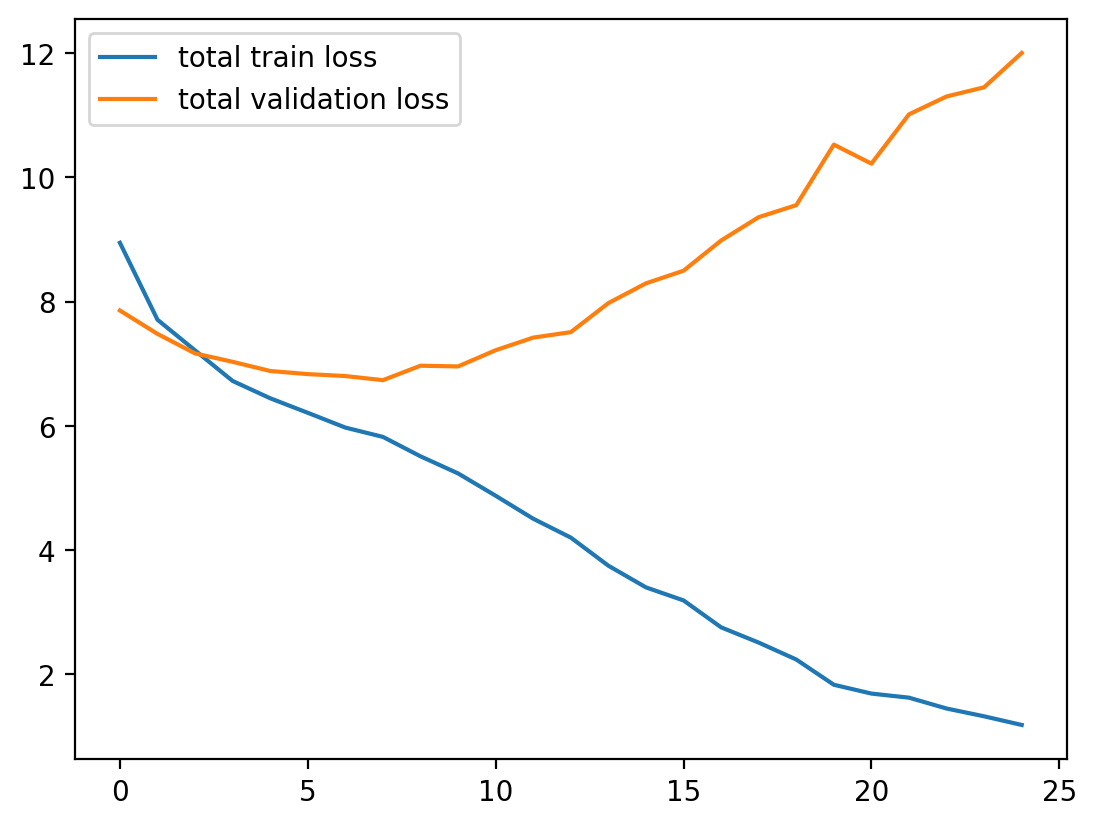

In [354]:
plt.plot(history.epoch, history.history['loss'], label='total train loss')
plt.plot(history.epoch, history.history['val_loss'], label='total validation loss')
plt.legend()
plt.show()

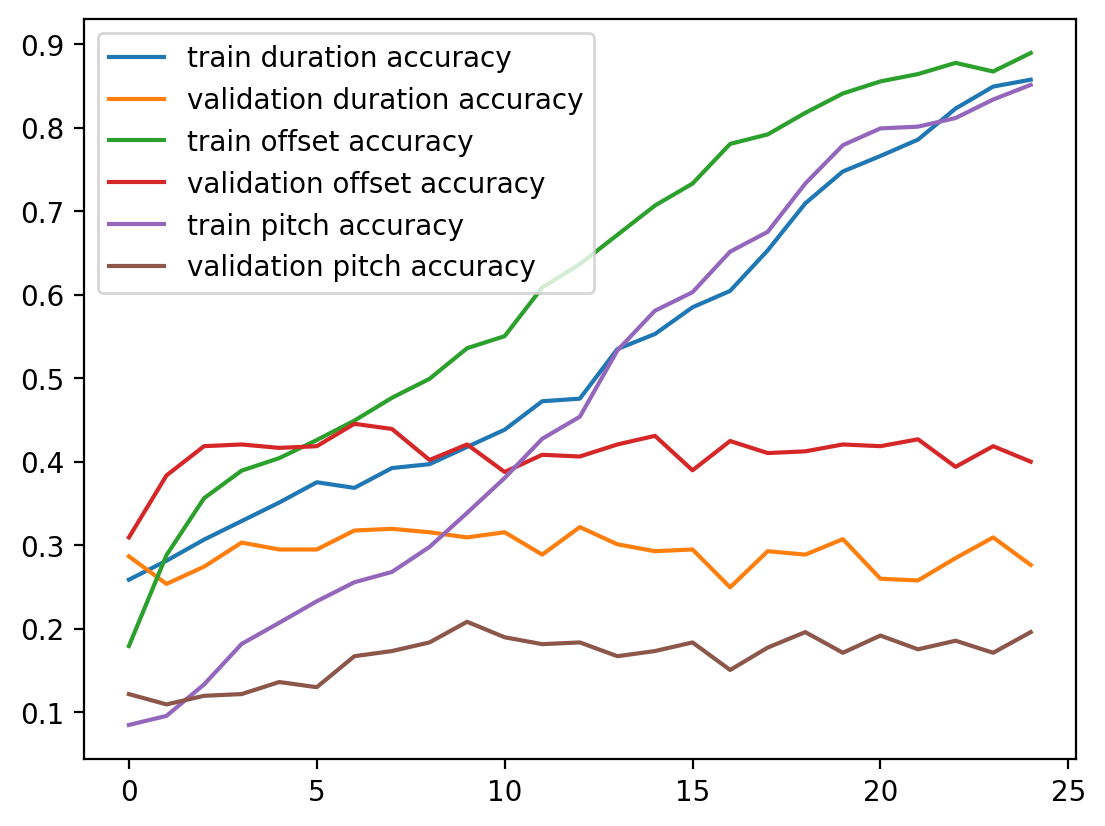

In [355]:
plt.plot(history.epoch, history.history['duration_accuracy'], label='train duration accuracy')
plt.plot(history.epoch, history.history['val_duration_accuracy'], label='validation duration accuracy')

plt.plot(history.epoch, history.history['offset_accuracy'], label='train offset accuracy')
plt.plot(history.epoch, history.history['val_offset_accuracy'], label='validation offset accuracy')

plt.plot(history.epoch, history.history['pitch_accuracy'], label='train pitch accuracy')
plt.plot(history.epoch, history.history['val_pitch_accuracy'], label='validation pitch accuracy')

plt.legend()
plt.show()

In [361]:
# creates 50 random notes
seed_notes = []
for i in range(50):
    pitch_index = random.randint(0, NUM_PIANO_KEYS - 1)
    pitch = np.zeros(NUM_PIANO_KEYS)
    pitch[pitch_index] = 1
    
    duration_index = random.randint(0, len(duration_map) - 1)
    duration = np.zeros(len(duration_map))
    duration[duration_index] = 1
    
    offset_index = random.randint(0, len(offset_map) - 1)
    offset = np.zeros(len(offset_map))
    offset[offset_index] = 1
    
    seed_notes.append(np.concatenate([pitch, duration, offset]))
    
seed_notes = np.asarray(seed_notes)

In [362]:
# select seed notes from training music
# seed_notes = inputs[0]

# turns the seed note vectors back into actual music21 notes
chord_builder = []
note_stream = []
offset = 0

for g in reversed(seed_notes):
    n = note.Note(np.argmax(g[:NUM_PIANO_KEYS]) + A0_MIDI_OFFSET)
    str_duration = reverse_duration[np.argmax(g[NUM_PIANO_KEYS : NUM_PIANO_KEYS + len(duration_map)])]
    try:
        n.quarterLength = float(str_duration)
    except:
        n.quarterLength = Fraction(str_duration)
    # if offset is 0, stores it so that it can be added to a chord
    offset = reverse_offset[np.argmax(g[-1 * len(offset_map):])]
    if offset == 0:
        chord_builder.append(n)
    elif len(chord_builder) == 0:
        note_stream.append((n, offset))
    else:
        note_stream.append((chord.Chord(chord_builder), offset))
        chord_builder = []
if len(chord_builder) == 1:
    note_stream.append((chord_builder[0], 0))
elif len(chord_builder) > 1:
    note_stream.append((chord.Chord(chord_builder), 0))
note_stream.reverse()

seed_stream = stream.Stream()
previous_offset = 0
for n, off in note_stream:
    previous_offset += off
    seed_stream.insert(previous_offset, n)

In [364]:
# generates new notes by adding the newly generated note to the end of the seed notes
num_notes = 100
generated_notes = []
for i in range(num_notes):
    new_note = model.predict(tf.expand_dims(seed_notes, 0))
    new_input = np.concatenate([new_note["pitch"], new_note["duration"], new_note["offset"]], axis = 1)
    generated_notes.append(new_note)
    seed_notes = np.delete(seed_notes, 0, axis = 0)
    seed_notes = np.append(seed_notes, new_input, axis = 0)

1/1 [==============================] - 0s 13ms/step


In [365]:
# turns the generated notes into music21 notes
chord_builder = []
note_stream = []
offset = 0
temperature = 1.5
for i in reversed(range(len(generated_notes))):
    g = generated_notes[i]
    probs = g["pitch"].reshape(-1)
    pitch_idx = np.random.choice(len(probs), p=probs**temperature/np.sum(probs**temperature))

    n = note.Note(pitch_idx + A0_MIDI_OFFSET)
    try:
        n.quarterLength = float(reverse_duration[np.argmax(g["duration"])])
    except:
        n.quarterLength = Fraction(reverse_duration[np.argmax(g["duration"])])
    # if offset is 0, stores it so that it can be added to a chord
    offset = reverse_offset[np.argmax(g["offset"])]
    if offset == 0:
        chord_builder.append(n)
    elif len(chord_builder) == 0:
        note_stream.append((n, offset))
    else:
        note_stream.append((chord.Chord(chord_builder), offset))
        chord_builder = []
if len(chord_builder) == 1:
    note_stream.append((chord_builder[0], 0))
elif len(chord_builder) > 1:
    note_stream.append((chord.Chord(chord_builder), 0))
note_stream.reverse()

s = stream.Stream()
previous_offset = 0
for n, off in note_stream:
    previous_offset += off
    s.insert(previous_offset, n)

In [367]:
# writes the midi file of the seed
seed_stream.write("midi", "seed.mid")

'seed.mid'

In [368]:
# used to play the seed music in notebook
seed_stream.show("midi")

In [369]:
# writes the midi file of the output
s.write("midi", "output.mid")

'output.mid'

In [370]:
# used to play the output music in notebook
s.show("midi")

In [335]:
# displays the sheet music version of the seed
# does not always work, usually does not if the notes do not fit into measures cleanly
seed_stream.show()

MusicXMLExportException: In part (None), measure (4): Cannot convert inexpressible durations to MusicXML.

In [ ]:
# displays the sheet music version of the output
# does not always work, usually does not if the notes do not fit into measures cleanly
s.show()